# MATH pre-train vs RL evaluation visualization

Use this notebook to collect GSM8K evaluation scores from pre-training and RL runs under `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results`, then plot how RL fine-tuning moves performance from its starting checkpoint.



In [1]:
from pathlib import Path
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Root location for evaluation outputs and the metric key to read
BASE_DIR = Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results")
DATASET_KEY = "test_score/DigitalLearningGmbH/MATH-lighteval"

print(f"Base directory: {BASE_DIR}")



Base directory: /n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results


In [2]:
def read_score(result_path: Path, samples: int, dataset_key: str = DATASET_KEY):
    """Read score from either dict-style logs or majority-vote text.

    - For majority files (samples > 1 or filename contains 'majority'), look for a line
      containing 'Pass@' and take the first float after the colon.
    - Otherwise, look for the last dict line containing the dataset_key.
    """
    if not result_path.exists():
        return None

    text = result_path.read_text().splitlines()

    # Majority-format text file (pass@k, single-sample accuracy, etc.)
    if samples > 1 or "majority" in result_path.name:
        for line in text:
            if "Pass@" in line:
                # Expect formats like: "Pass@32 (Any Correct):            0.6884 (68.84%)"
                parts = line.split(":")
                if len(parts) > 1:
                    try:
                        return float(parts[1].split()[0])
                    except Exception:
                        pass
                # Fallback: grab first float on the line
                import re as _re
                match = _re.search(r"([0-9]*\.?[0-9]+)", line)
                if match:
                    try:
                        return float(match.group(1))
                    except Exception:
                        pass
        # If we didn't find Pass@, fall back to the dict parsing below

    # Dict-style log: scan from the bottom for a dict containing the key
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and dataset_key in payload:
            return payload[dataset_key]
    return None

# Collect pre-train runs (pattern: 1B-step{step}-{shot}shot-{samples}samples-temp{temp})
pretrain_rows = []
pre_pattern = re.compile(r"1B-step(?P<step>\d+)-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")

# Collect RL runs from both naming schemes below
#   1) 1B-step{pt_step}-rl-step{rl_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) olmo2_1b_step{pt_step}_omigsm8k-step{rl_step}-rl-0shot-boxed-{samples}samples-temp{temp}
rl_rows = []
rl_patterns = [
    re.compile(r"1B-step(?P<pt_step>\d+)-rl-step(?P<rl_step>\d+)-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k_n(?P<num_rollouts>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omi_n(?P<num_rollouts>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
]

# Collect SFT runs
#   1) 1B-step{pt_step}-sft-step{sft_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) OLMo2-1B-step{pt_step}-stage2-openmathgsm8k-step{sft_step}-hf-{shot}shot-{samples}samples-temp{temp}
sft_rows = []
sft_patterns = [
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-5epoch-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
]

for path in BASE_DIR.iterdir():
    if not path.is_dir():
        continue
    name = path.name

    # Pre-train collection
    pre_match = pre_pattern.match(name)
    if pre_match and not any(tag in name for tag in ["-rl-", "-sft-", "-hf"]):
        samples = int(pre_match.group("samples"))
        result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
        score = read_score(path / result_file, samples=samples)
        pretrain_rows.append(
            {
                "step": int(pre_match.group("step")),
                "shot": int(pre_match.group("shot")),
                "samples": samples,
                "temp": float(pre_match.group("temp")),
                "score": score,
                "path": str(path),
            }
        )
        continue

    # RL collection (first pattern that matches wins)
    matched = False
    for pat in rl_patterns:
        rl_match = pat.match(name)
        if rl_match:
            samples = int(rl_match.group("samples"))
            result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
            score = read_score(path / result_file, samples=samples)
            pt_step = int(rl_match.group("pt_step"))
            rl_step = int(rl_match.group("rl_step"))
            rl_rows.append(
                {
                    "pt_step": pt_step,
                    "rl_step": rl_step,
                    "total_step": pt_step + rl_step,
                    "samples": samples,
                    "temp": float(rl_match.group("temp")),
                    "score": score,
                    "path": str(path),
                    "label": name,
                }
            )
            matched = True
            break
    if matched:
        continue

    # SFT collection (first pattern that matches wins)
    for pat in sft_patterns:
        sft_match = pat.match(name)
        if sft_match:
            samples = int(sft_match.group("samples"))
            shot = int(sft_match.group("shot")) if "shot" in sft_match.groupdict() else None
            result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
            score = read_score(path / result_file, samples=samples)
            pt_step = int(sft_match.group("pt_step"))
            sft_step = int(sft_match.group("sft_step"))
            if "5epoch" in name:
                epochs = 5
            else:
                epochs = 1
            sft_rows.append(
                {
                    "pt_step": pt_step,
                    "sft_step": sft_step,
                    "total_step": pt_step + sft_step,
                    "shot": shot,
                    "samples": samples,
                    "temp": float(sft_match.group("temp")),
                    "score": score,
                    "path": str(path),
                    "label": name,
                    "sft_epochs": epochs,
                }
            )
            break

pre_df = pd.DataFrame(pretrain_rows)
rl_df = pd.DataFrame(rl_rows)
sft_df = pd.DataFrame(sft_rows)

print(f"Loaded {len(pre_df)} pre-train runs, {len(rl_df)} RL runs, {len(sft_df)} SFT runs.")



Loaded 139 pre-train runs, 165 RL runs, 63 SFT runs.


In [3]:
display(pre_df.sort_values(["step", "shot", "samples", "temp"]))
print()
display(rl_df.sort_values(["pt_step", "rl_step", "samples", "temp"]))
print()
display(sft_df.sort_values(["pt_step", "sft_step", "samples", "temp"]))



,step,shot,samples,temp,score,path
1,1000,0,1,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
3,1000,0,8,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
2,1000,0,32,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
0,1000,0,128,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
5,1000,1,1,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
...,...,...,...,...,...,...
76,22000,8,8,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
77,22000,8,8,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
74,22000,8,32,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
75,22000,8,32,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...


,pt_step,rl_step,total_step,samples,temp,score,path,label
34,1000,100,1100,1,0.6,0.0328,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...
36,1000,100,1100,8,0.6,0.0664,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...
35,1000,100,1100,32,0.6,0.0862,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...
33,1000,100,1100,128,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...
38,1000,300,1300,1,0.6,0.0398,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step300-rl-0shot-box...
...,...,...,...,...,...,...,...,...
97,22000,800,22800,128,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n5-step800-rl-0sho...
80,22000,1000,23000,1,0.6,0.0972,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n64-step1000-rl-0shot-b...
82,22000,1000,23000,8,0.6,0.1882,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n64-step1000-rl-0shot-b...
81,22000,1000,23000,32,0.6,0.2616,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n64-step1000-rl-0shot-b...


,pt_step,sft_step,total_step,shot,samples,temp,score,path,label,sft_epochs
33,3000,285,3285,0,1,0.0,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
35,3000,285,3285,0,8,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
34,3000,285,3285,0,32,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
32,3000,285,3285,0,128,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
28,3000,1389,4389,0,1,0.0,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-5epoch-...,5
...,...,...,...,...,...,...,...,...,...,...
19,22000,1389,23389,0,1,0.0,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5
20,22000,1389,23389,0,1,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5
22,22000,1389,23389,0,8,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5
21,22000,1389,23389,0,32,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5


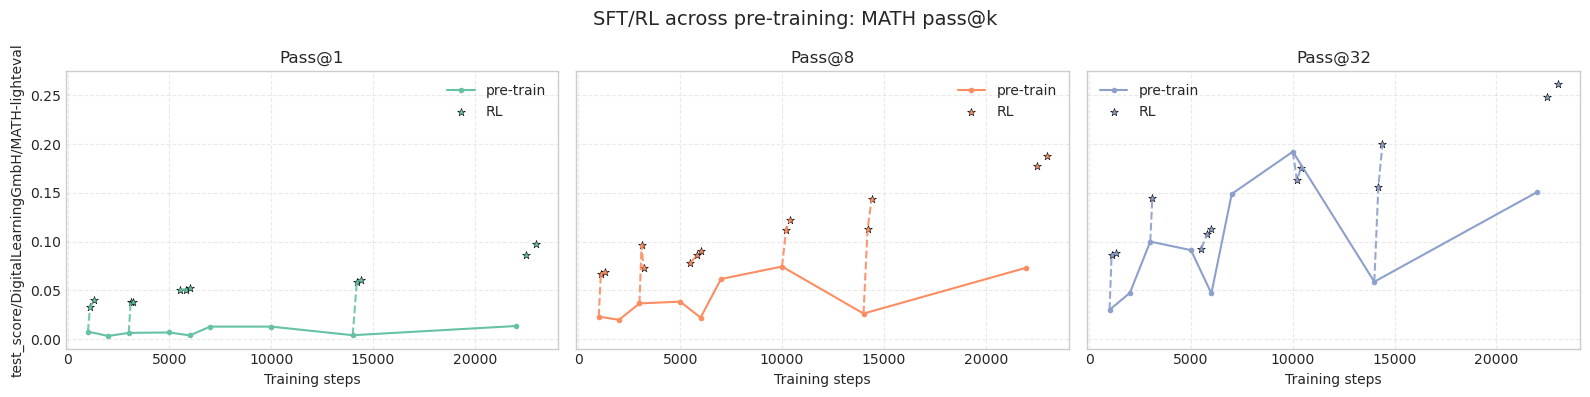

In [7]:
# Refined plotting: per-k subplots, cleaner legend markers, no RL/SFT marker at start
PLOT_SAMPLES = [1, 8, 32]
BASE_PRETRAIN_SHOT = 1
SHOT_BY_SAMPLES = lambda s: BASE_PRETRAIN_SHOT
TEMP_BY_SAMPLES = lambda s: 0.6

available_samples = sorted(set(pre_df["samples"]).union(rl_df["samples"]).union(sft_df["samples"]))
plot_samples = [s for s in PLOT_SAMPLES if s in available_samples]

plt.style.use("seaborn-v0_8-whitegrid")

if not plot_samples:
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.text(0.5, 0.5, "No runs for the selected samples/temp", transform=ax.transAxes, ha="center")
    plt.show()
else:
    n = len(plot_samples)
    ncols = n  # 2 if n > 1 else 1
    nrows = 1  # (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows), sharey=True)
    axes = axes.flatten() if n > 1 else [axes]
    cmap = plt.get_cmap("Set2")

    for idx, samples in enumerate(plot_samples):
        ax = axes[idx]
        target_temp = TEMP_BY_SAMPLES(samples)
        shot = SHOT_BY_SAMPLES(samples)
        color = cmap(idx % cmap.N)

        pre_curve = pre_df[(pre_df["samples"] == samples) & (pre_df["shot"] == shot) & (pre_df["temp"] == target_temp)].sort_values("step")
        if not pre_curve.empty:
            ax.plot(pre_curve["step"], pre_curve["score"], marker=".", color=color, label="pre-train")

        # RL
        rl_curve = rl_df[(rl_df["samples"] == samples) & (rl_df["temp"] == target_temp)].sort_values(["pt_step", "rl_step"])
        rl_labeled = False
        for pt_step, group in rl_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("rl_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["rl_step"]).tolist())
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            ax.plot(xs, ys, linestyle="--", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="*", color=color, s=35, edgecolor="k", linewidth=0.4, label="RL" if not rl_labeled else None)
                rl_labeled = True

        # # SFT standard
        # sft_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 1) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        # sft_labeled = False
        # for pt_step, group in sft_curve.groupby("pt_step"):
        #     pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
        #     start_score = pre_match.iloc[0] if not pre_match.empty else None
        #     group_sorted = group.sort_values("sft_step")
        #     xs = [pt_step] if start_score is not None else []
        #     ys = [start_score] if start_score is not None else []
        #     xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
        #     ys.extend(group_sorted["score"].tolist())
        #     if not xs:
        #         continue
        #     ax.plot(xs, ys, linestyle=":", marker=None, color=color, alpha=0.9)
        #     if len(xs) > 1:
        #         ax.scatter(xs[1:], ys[1:], marker="d", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT" if not sft_labeled else None)
        #         sft_labeled = True

        # # SFT 5-epoch
        # sft5_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 5) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        # sft5_labeled = False
        # for pt_step, group in sft5_curve.groupby("pt_step"):
        #     pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
        #     start_score = pre_match.iloc[0] if not pre_match.empty else None
        #     group_sorted = group.sort_values("sft_step")
        #     xs = [pt_step] if start_score is not None else []
        #     ys = [start_score] if start_score is not None else []
        #     xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
        #     xs = [(pt_step + (x - pt_step)//5) for x in xs]
        #     ys.extend(group_sorted["score"].tolist())
        #     if not xs:
        #         continue
        #     # ax.plot(xs, ys, linestyle="-.", marker=None, color=color, alpha=0.9)
        #     if len(xs) > 1:
        #         ax.scatter(xs[1:], ys[1:], marker="d", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT-5ep" if not sft5_labeled else None, alpha=0.6)
        #         sft5_labeled = True

        ax.set_title(f"Pass@{samples}")
        ax.set_xlabel("Training steps")
        if idx % ncols == 0:
            ax.set_ylabel(DATASET_KEY)
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend()

    fig.suptitle(f"SFT/RL across pre-training: MATH pass@k", fontsize=14)
    plt.tight_layout()
    plt.show()



In [5]:
# fineweb-math for pre-training
# tiny-gsm numbers
# how back we can push the RL
# maybe we can push it way back and make up for pre-training but having to spend lot more FLOPs on RL
# poking around datasets

In [6]:
# Concise table with columns for pass@1/8/32/128 (pre, best SFT, best RL)
TARGET_KS = [1, 8, 32, 128]

rows = []
all_steps = sorted(pre_df["step"].unique().tolist())
for step in all_steps:
    row = {"pt_step": step}
    for k in TARGET_KS:
        temp = TEMP_BY_SAMPLES(k)
        shot = SHOT_BY_SAMPLES(k)

        pre_slice = pre_df[(pre_df["step"] == step) & (pre_df["samples"] == k) & (pre_df["temp"] == temp) & (pre_df["shot"] == shot)]
        row[f"pre_p{k}"] = pre_slice.iloc[-1]["score"] if not pre_slice.empty else None

        sft_slice = sft_df[(sft_df["pt_step"] == step) & (sft_df["samples"] == k) & (sft_df["temp"] == temp)]
        if not sft_slice.empty:
            best_sft = sft_slice.loc[sft_slice["total_step"].idxmax()]
            row[f"sft_p{k}"] = best_sft["score"]
            # row[f"sft_step{k}"] = best_sft["total_step"]
        else:
            row[f"sft_p{k}"] = None
            # row[f"sft_step{k}"] = None

        rl_slice = rl_df[(rl_df["pt_step"] == step) & (rl_df["samples"] == k) & (rl_df["temp"] == temp)]
        if not rl_slice.empty:
            best_rl = rl_slice.loc[rl_slice["total_step"].idxmax()]
            row[f"rl_p{k}"] = best_rl["score"]
            # row[f"rl_step{k}"] = best_rl["total_step"]
        else:
            row[f"rl_p{k}"] = None
            # row[f"rl_step{k}"] = None

    rows.append(row)

concise_df = pd.DataFrame(rows).sort_values("pt_step").reset_index(drop=True)
concise_df



,pt_step,pre_p1,sft_p1,rl_p1,pre_p8,sft_p8,rl_p8,pre_p32,sft_p32,rl_p32,pre_p128,sft_p128,rl_p128
0,1000,0.0076,None,NaN,0.0230,None,NaN,0.0300,None,NaN,NaN,None,NaN
1,2000,0.0032,None,NaN,0.0198,None,NaN,0.0474,None,NaN,0.0976,None,NaN
2,3000,0.0064,None,NaN,0.0366,None,NaN,0.1000,None,NaN,0.1946,None,NaN
3,5000,0.0068,None,0.0522,0.0384,None,0.0908,0.0912,None,0.1130,0.1752,None,NaN
4,6000,0.0038,None,NaN,0.0220,None,NaN,0.0468,None,NaN,0.0948,None,NaN
5,7000,0.0128,None,NaN,0.0616,None,NaN,0.1488,None,NaN,0.2840,None,NaN
6,10000,0.0128,None,NaN,0.0744,None,NaN,0.1922,None,NaN,0.3382,None,NaN
7,14000,0.0040,None,NaN,0.0262,None,NaN,0.0588,None,NaN,0.1198,None,NaN
8,22000,0.0134,None,0.0972,0.0732,None,0.1882,0.1508,None,0.2616,0.2612,None,NaN
